In [1]:
import torch
from monai.networks.nets import SwinUNETR
import os
import time
from monai.inferers import sliding_window_inference
from scipy import ndimage
from matplotlib import pyplot as plt

from monai.transforms import (
    AsDiscrete,
    AddChanneld,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    ToTensord,
)

from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)

In [2]:
num_samples = 1

train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-175,
            a_max=250,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=num_samples,
            image_key="image",
            image_threshold=0,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=0.10,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
        RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
        ),
        ToTensord(keys=["image", "label"]),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        ToTensord(keys=["image", "label"]),
    ]
)

In [6]:
data_dir = ""
split_JSON = "task1_dataset-Copy1.json"
datasets = data_dir + split_JSON
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=24,
    cache_rate=1.0,
    num_workers=8,
)
train_loader = DataLoader(
    train_ds, batch_size=1, shuffle=True, num_workers=8,
)
val_ds = CacheDataset(
    data=val_files, transform=val_transforms, cache_num=16,
 cache_rate=1.0, num_workers=8
)
val_loader = DataLoader(
    val_ds, batch_size=1, num_workers=8
)

Loading dataset: 100%|██████████| 16/16 [00:32<00:00,  2.05s/it]


amos_0387.nii.gz


None of the inputs have requires_grad=True. Gradients will be None


image shape: torch.Size([1, 279, 210, 261]), label shape: torch.Size([1, 279, 210, 261])


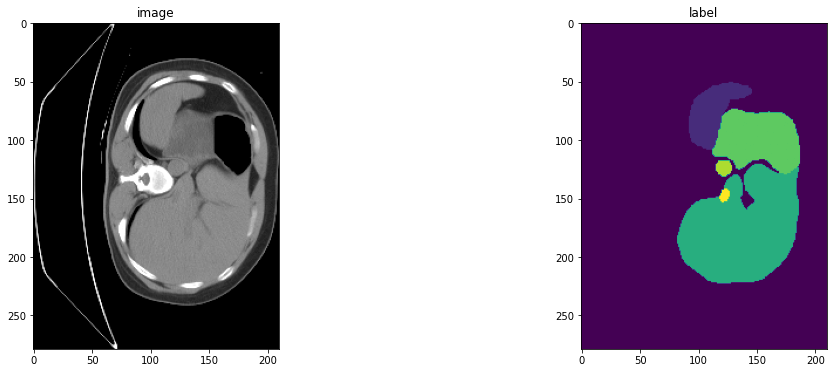

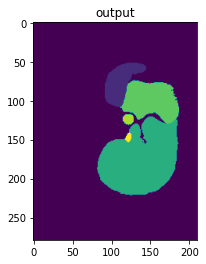

236.11591172218323


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
size = (64, 64, 64)

model = SwinUNETR(
    img_size=size,
    in_channels=1,
    out_channels=14,
    feature_size=48, #48
    use_checkpoint=True,
).to(device)

start_time = time.time()
slice_map = {
    "amos_0383.nii.gz": 170,
    "amos_0384.nii.gz": 230,
    "amos_0387.nii.gz": 204,
    "amos_0388.nii.gz": 204,
    "amos_0390.nii.gz": 204,
    "amos_0391.nii.gz": 204,
    "amos_0392.nii.gz": 204,
    "amos_0395.nii.gz": 180,
}
case_num = 2
model.load_state_dict(torch.load(os.path.join('models', "best_metric_model.pth")))
model.eval()
with torch.no_grad():

    img_name = os.path.split(val_ds[case_num]["image_meta_dict"]["filename_or_obj"])[1]
    print(img_name)
    img = val_ds[case_num]["image"]
    label = val_ds[case_num]["label"]

    val_inputs = torch.unsqueeze(img, 1).cuda()
    val_labels = torch.unsqueeze(label, 1).cuda()
    val_outputs = sliding_window_inference(
        val_inputs, (64,64,64), 4, model, overlap=0.8
    )

    img_shape = img.shape
    label_shape = label.shape
    print(f"image shape: {img_shape}, label shape: {label_shape}")
    plt.figure("image", (18, 6))
    plt.subplot(1, 2, 1)
    plt.title("image")
    plt.imshow(img[0, :, :, slice_map[img_name]].detach().cpu(), cmap="gray")
    rot_im = ndimage.rotate(img[0,:,:, slice_map[img_name]].detach().cpu(), 90)
#     plt.imshow(rot_im)
    plt.subplot(1, 2, 2)
    plt.title("label")
    plt.imshow(label[0, :, :, slice_map[img_name]].detach().cpu())
    plt.show()
    plt.title("output")
    plt.imshow(
        torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, slice_map[img_name]]
    )
    plt.show()
    end_time = time.time()
    total = (end_time - start_time)
    print(total)